In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('lending_club_ml.csv')
df.drop(['id'], inplace=True, axis=1)
df.info()

In [ ]:
for thing in df:
    if df[thing].dtype == 'object':
        print(thing)

In [6]:
# creating columns for features that had more than 2 outcomes
# I have decided to use subgrade and not grade as these are suppose to be similar features but, subgrade is more granular

df = pd.concat([df, pd.get_dummies(
    df.sub_grade, prefix='sub_grade', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.home_ownership,
                                   prefix='home_ownership', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.verification_status,
                                   prefix='verification_status', drop_first=True)], axis=1)
df = pd.concat(
    [df, pd.get_dummies(df.purpose, prefix='purpose', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.verification_status_joint,
                                   prefix='verification_status_joint', drop_first=True)], axis=1)

df.drop(columns=['sub_grade', 'home_ownership', 'verification_status',
                 'purpose', 'verification_status_joint'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506738 entries, 0 to 2506737
Columns: 148 entries, loan_amnt to verification_status_joint_Verified
dtypes: float64(89), int64(3), object(3), uint8(53)
memory usage: 1.9+ GB


In [7]:
# conversions for features that only had 2 outcomes

df.disbursement_method = df.disbursement_method.apply(
    lambda disburstment: 1 if disburstment == 'Cash' else 0)

For the time being I have decided to drop grade in favor sub grade

I have decided to drop the split the data into two different sets: individual and the joint. I believe that these are fundamentally 2 different kinds of loans. In our EDA we saw that joint applicants had wide ranges in their FICO scores and in addition joint applicants are subjected to a second group of variables.

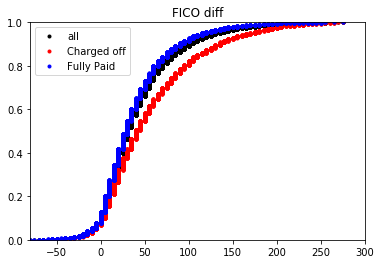

All Loans

count    23510.000000

mean        41.753977

std         44.937476

min        -80.000000

25%         10.000000

50%         30.000000

75%         60.000000

max        275.000000

Name: diff_fico_high, dtype: float64

Bad Loans (21%)

count    5032.000000

mean       56.096979

std        55.197095

min       -60.000000

25%        15.000000

50%        40.000000

75%        85.000000

max       275.000000

Name: diff_fico_high, dtype: float64


Passing Loans (78.59%)

count    18478.000000

mean        37.848036

std         40.846952

min        -80.000000

25%         10.000000

50%         30.000000

75%         55.000000

max        275.000000

Name: diff_fico_high, dtype: float64

In [8]:
df_i = df.loc[df.application_type == 'Individual']
df_j = df.loc[df.application_type != 'Individual']

df_i.drop(columns=['application_type'], inplace=True)
df_j.drop(columns=['application_type'], inplace=True)

In [9]:
for thing in df_i:
    if df_i[thing].isnull().values.any():
        print(thing)

inq_last_6mths
mths_since_last_delinq
mths_since_last_record
collections_12_mths_ex_med
mths_since_last_major_derog
annual_inc_joint
dti_joint
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit
revol_bal_joint
sec_app_fico_range_l

I will drop all features associated with a secondary borrower and fill all the nans with the averages of their respective features.

In [10]:
for thing in df_i:
    if df_i[thing].isnull().values.any():
        df_i[thing].fillna(np.mean(df_i[thing]), inplace=True)

In [8]:
# Dropping all joint and secondary linked features

df_i.drop(columns=['sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
                   'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
                   'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'dti_joint', 'sec_app_open_act_il',
                   'revol_bal_joint', 'annual_inc_joint'], inplace=True)

In [9]:
df_i.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2470188 entries, 0 to 2506736
Columns: 133 entries, loan_amnt to verification_status_joint_Verified
dtypes: float64(75), int64(4), object(1), uint8(53)
memory usage: 1.6+ GB


ML for regular loans

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


def scoring(clf, x, y):

    print('score: ', clf.score(x, y))

    # score adjusted for loan amount
    print('balanced_accuracy_score: ', balanced_accuracy_score(
        y, clf.predict(x), sample_weight=x['loan_amnt']))

    print(confusion_matrix(y, clf.predict(x)))
    print('F1 score: ', f1_score(y, clf.predict(x)))
    print('precision_score: ', precision_score(y, clf.predict(x)))

    # score adjusted for loan amount
    print('average_precision_score: ', average_precision_score(
        y, clf.predict(x), average='weighted', sample_weight=x['loan_amnt']))
    print('recall_score: ', recall_score(y, clf.predict(x)))

    # score adjusted for loan amount
    print('roc: ', roc_auc_score(y, clf.predict_proba(x)[
          :, 1], average='weighted', sample_weight=x['loan_amnt']))

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


def ML(dataframe):
    X = dataframe.drop(['loan_status'], axis=1)
    y = dataframe.loan_status

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

    print('Loan passing rate:', np.mean(y))
    print('Balanced loan passing rate:', np.average(y, weights=X['loan_amnt']))

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    print('\n')
    print('RANDOM FOREST')
    scoring(rf, X_test, y_test)

In [14]:
ML(df_i.drop(['grade'], axis=1))

Loan passing rate: 0.8017543603968604
Balanced loan passing rate: 0.7865625084365181


DECISION TREE
score:  0.9113023694533618
balanced_accuracy_score:  0.8665715636303318
[[115819  31002]
 [ 34728 559508]]
F1 score:  0.9445197536011938
precision_score:  0.9474996189734297
average_precision_score:  0.9342896038514932
recall_score:  0.9415585726882922
roc:  0.8665715636303319


RANDOM FOREST
score:  0.9280797563480272
balanced_accuracy_score:  0.8589818660155971
[[108210  38611]
 [ 14686 579550]]
F1 score:  0.9560399770042322
precision_score:  0.9375389259432413
average_precision_score:  0.929723967239627
recall_score:  0.9752859133408276
roc:  0.9366621962128227


ML for joint loans

In [15]:
df_j.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36550 entries, 448539 to 2506737
Columns: 147 entries, loan_amnt to verification_status_joint_Verified
dtypes: float64(89), int64(4), object(1), uint8(53)
memory usage: 28.3+ MB


In [16]:
for thing in df_j:
    if df_j[thing].isnull().values.any():
        df_j[thing].fillna(np.mean(df_j[thing]), inplace=True)

In [17]:
Xj = df_j.drop(['loan_status'], axis=1)
yj = df_j.loan_status

Xj_train, Xj_test, yj_train, yj_test = train_test_split(
    Xj, yj, test_size=0.3, random_state=42)

In [18]:
ML(df_j.drop(['grade'], axis=1))

Loan passing rate: 0.7743365253077975
Balanced loan passing rate: 0.7699130763185922


DECISION TREE
score:  0.8991336069311445
balanced_accuracy_score:  0.8478415467162204
[[1957  586]
 [ 520 7902]]
F1 score:  0.934594914251922
precision_score:  0.930961357210179
average_precision_score:  0.9157286989613425
recall_score:  0.9382569460935645
roc:  0.8478415467162206


RANDOM FOREST
score:  0.9140902872777018
balanced_accuracy_score:  0.8449562724990509
[[1853  690]
 [ 252 8170]]
F1 score:  0.9454924198588126
precision_score:  0.9221218961625283
average_precision_score:  0.9132043976345038
recall_score:  0.9700783661838043
roc:  0.9230906131109354


So the scores were pretty similar for both class of loans. Although it was slightly lower for joint loans. Unfortunately logistic regression seems to be a horrible classifier. (moved to different notebook) Not only does it have the lowest score it also predicted that only 6 loans were bad and out of that 3 were actually true! 

ALL TOGETHER NOW, ML for the whole data set

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506738 entries, 0 to 2506737
Columns: 148 entries, loan_amnt to verification_status_joint_Verified
dtypes: float64(89), int64(4), object(2), uint8(53)
memory usage: 1.9+ GB


If the loan was an individual loan then it will be filled by its single counter part feature. 

In [12]:
df.application_type = df.application_type.apply(
    lambda app_type: 1 if app_type == 'Individual' else 0)

In [13]:
sec_list = ['sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
            'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
            'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'sec_app_open_act_il']
joint_list = ['dti_joint', 'revol_bal_joint', 'annual_inc_joint']

for secondary in sec_list:
    df.loc[df.application_type ==
           1][secondary] = df.loc[df.application_type == 1][secondary[8:]]

for joint in joint_list:
    df.loc[df.application_type ==
           1][joint] = df.loc[df.application_type == 1][joint[:len(joint)-6]]

In [14]:
for thing in df:
    if df[thing].isnull().values.any():
        df[thing].fillna(np.mean(df[thing]), inplace=True)

In [23]:
ML(df.drop(['grade'], axis=1))

Loan passing rate: 0.8013545891114269
Balanced loan passing rate: 0.7862376557561834


DECISION TREE
score:  0.9112658938169362
balanced_accuracy_score:  0.8662769295717845
[[118111  31566]
 [ 35164 567181]]
F1 score:  0.9444422242426058
precision_score:  0.9472799028638139
average_precision_score:  0.9337699906937731
recall_score:  0.9416214959865193
roc:  0.8662769295717844


RANDOM FOREST
score:  0.9280140740563441
balanced_accuracy_score:  0.8597924058058147
[[110686  38991]
 [ 15144 587201]]
F1 score:  0.9559353930732245
precision_score:  0.937733155326162
average_precision_score:  0.9297009475855507
recall_score:  0.9748582622915439
roc:  0.9375659620724596


In [21]:
from sklearn.model_selection import GridSearchCV

parameters = {'class_weight': ['balanced', None],
              'criterion':['gini','entropy'],
              'n_estimators': [101]}

rf = RandomForestClassifier()

rf_cv = GridSearchCV(rf, parameters, cv=2)

X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(
    df.drop(['grade', 'loan_status'], axis=1), df.loan_status, test_size=0.3, random_state=42)

rf_cv.fit(X_avg_train, y_avg_train)

scoring(rf_cv, X_avg_test, y_avg_test)

rf_cv.best_params_

score:  0.9412916111496739
balanced_accuracy_score:  0.8597039288899948
[[107991  41686]
 [  2464 599881]]
F1 score:  0.9645071355529972
precision_score:  0.9350247129294368
average_precision_score:  0.9290039395777568
recall_score:  0.9959093210701508
roc:  0.9652671297449752


{'class_weight': None, 'criterion': 'entropy', 'n_estimators': 101}

In [22]:
rf_cv.cv_results_

{'mean_fit_time': array([539.47004259, 579.28215313, 539.25136995, 644.06235492]),
 'std_fit_time': array([3.80012167, 4.03264499, 0.56094122, 8.00005352]),
 'mean_score_time': array([47.94412315, 43.4956435 , 47.31172156, 51.22243512]),
 'std_score_time': array([0.63977158, 0.03485715, 0.12458658, 0.9015063 ]),
 'param_class_weight': masked_array(data=['balanced', 'balanced', None, None],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_criterion': masked_array(data=['gini', 'entropy', 'gini', 'entropy'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[101, 101, 101, 101],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'class_weight': 'balanced',
   'criterion': 'gini',
   'n_estimators': 101},
  {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 10

In [18]:
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(
    df.drop(['grade', 'loan_status'], axis=1), df.loan_status, test_size=0.3, random_state=42)

In [20]:
rf_100 = RandomForestClassifier(n_estimators=100)

rf_100.fit(X_avg_train, y_avg_train)

scoring(rf_100, X_avg_test, y_avg_test)

score:  0.9414126182478704
balanced_accuracy_score:  0.8609267894145756
[[108356  41321]
 [  2738 599607]]
F1 score:  0.9645620873291707
precision_score:  0.9355294198412302
average_precision_score:  0.9295926701946172
recall_score:  0.9954544322605816
roc:  0.9644705009867246


In [19]:
rf_200 = RandomForestClassifier(n_estimators=200)

rf_200.fit(X_avg_train, y_avg_train)

scoring(rf_200, X_avg_test, y_avg_test)

score:  0.9414245859828568
balanced_accuracy_score:  0.85934906663379
[[107789  41888]
 [  2162 600183]]
F1 score:  0.9646018694713023
precision_score:  0.9347611089739297
average_precision_score:  0.9288199970978425
recall_score:  0.9964106948675593
roc:  0.9661410413744417


In [ ]:
rf_500 = RandomForestClassifier(n_estimators=500)

rf_500.fit(X_avg_train, y_avg_train)

scoring(rf_500, X_avg_test, y_avg_test)

In [17]:
rf_1000 = RandomForestClassifier(n_estimators=1000)

rf_1000.fit(X_avg_train, y_avg_train)

scoring(rf_1000, X_avg_test, y_avg_test)

score:  0.9416240482326315
balanced_accuracy_score:  0.8589446550819144
[[107561  42116]
 [  1784 600561]]
F1 score:  0.9647395788990074
precision_score:  0.934467858659949
average_precision_score:  0.9286076510679641
recall_score:  0.9970382422033884
roc:  0.9674843087953633


Scores from highest to lowest: individual, all, then joint. I wouldn't exactly say this is is a fair comparison since we used different fill nan values, different set of features, and had different sample sizes. Although generally speaking joint loans seem harder to classify. This may have brought down scores for ml_all. 

We are going to try and see if we can get better scores among each grade of loans.

ML for different grades

Before we do this I want to see the results of the previous classifers on differnt grades. As we saw during our EDA lower grade loans failed at larger rates. We will be use the results from df_ml as the score since we will be lumping together joint and individual loans.

results of grades

In [45]:
def grade_testing2(df_grade):
    X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(
        df_grade.drop(['loan_status','grade'], axis=1), df_grade.loan_status, test_size=0.3, random_state=42)

    rf_defalut = RandomForestClassifier()
    print('Loan passing rate:', np.mean(df_grade.loan_status))
    print('Balanced loan passing rate:', np.average(
        df_grade.loan_status, weights=df_grade['loan_amnt']))

    rf_defalut.fit(X_avg_train, y_avg_train)
    print('Random Forest')
    scoring(rf_defalut, X_avg_test, y_avg_test)
    print('\n1000 tree forest')
    scoring(rf, X_avg_test, y_avg_test)

In [51]:
grades = set(df.grade)

for loan_grade in sorted(grades):
    print(loan_grade)
    grade_testing2(df.loc[df.grade==loan_grade])
    print('\n')

A
Loan passing rate: 0.9401064589718183
Balanced loan passing rate: 0.9411077425533958
Random Forest
score:  0.9787619727938183
balanced_accuracy_score:  0.8257767518525029
[[  5097   2648]
 [   117 122329]]
F1 score:  0.9888248061012921
precision_score:  0.9788121014266625
average_precision_score:  0.9787697253112554
recall_score:  0.9990444767489343
roc:  0.9001954839635423

1000 tree forest
score:  0.9946232842515996
balanced_accuracy_score:  0.9570392949224038
[[  7045    700]
 [     0 122446]]
F1 score:  0.9971497442913451
precision_score:  0.9943156903188086
average_precision_score:  0.99467947023111
recall_score:  1.0
roc:  0.9937084594435013


B
Loan passing rate: 0.8674153371750992
Balanced loan passing rate: 0.864957609485713
Random Forest
score:  0.9510486005749876
balanced_accuracy_score:  0.833260952499356
[[ 19526   9589]
 [  1155 189213]]
F1 score:  0.972392527687129
precision_score:  0.9517660788120844
average_precision_score:  0.9506081252258668
recall_score:  0.993932

KeyboardInterrupt: 

In [19]:
# will fill nas with average of respective grades
def grade_df(dataframe_grade):
    for thing in dataframe_grade:
        if dataframe_grade[thing].isnull().values.any():
            dataframe_grade[thing].fillna(
                np.mean(dataframe_grade[thing]), inplace=True)

    dataframe_grade.drop(columns=['grade'], inplace=True)

    return dataframe_grade

In [ ]:
df1 = pd.read_csv('lending_club_ml.csv')
df1.drop(['id'], inplace=True, axis=1)

df1 = pd.concat([df, pd.get_dummies(
    df1.sub_grade, prefix='sub_grade', drop_first=True)], axis=1)
df1 = pd.concat([df1, pd.get_dummies(df.home_ownership,
                                   prefix='home_ownership', drop_first=True)], axis=1)
df1 = pd.concat([df1, pd.get_dummies(df.verification_status,
                                   prefix='verification_status', drop_first=True)], axis=1)
df1 = pd.concat(
    [df1, pd.get_dummies(df.purpose, prefix='purpose', drop_first=True)], axis=1)
df1 = pd.concat([df1, pd.get_dummies(df.verification_status_joint,
                                   prefix='verification_status_joint', drop_first=True)], axis=1)

df1.drop(columns=['sub_grade', 'home_ownership', 'verification_status',
                 'purpose', 'verification_status_joint'], inplace=True)

df1.disbursement_method = df1.disbursement_method.apply(
    lambda disburstment: 1 if disburstment == 'Cash' else 0)

df1.application_type = df1.application_type.apply(
    lambda app_type: 1 if app_type == 'Individual' else 0)

In [34]:
def grade_testing(df_grade):
    X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(
        df_grade.drop(['loan_status'], axis=1), df_grade.loan_status, test_size=0.3, random_state=42)

    rf_defalut = RandomForestClassifier()
    print('Loan passing rate:', np.mean(df_grade.loan_status))
    print('Balanced loan passing rate:', np.average(
        df_grade.loan_status, weights=df_grade['loan_amnt']))

    rf_defalut.fit(X_avg_train, y_avg_train)
    print('Random Forest')
    scoring(rf_defalut, X_avg_test, y_avg_test)
    print('\n1000 tree forest')
    scoring(rf, X_avg_test, y_avg_test)

In [35]:
df_a = grade_df(df.loc[df.grade == 'A'])

grade_testing(df_a)

Loan passing rate: 0.9401064589718183
Balanced loan passing rate: 0.9411077425533958
Random Forest
score:  0.9790000844912474
balanced_accuracy_score:  0.8289251175210524
[[  5127   2618]
 [   116 122330]]
F1 score:  0.9889488023153351
precision_score:  0.9790472836700067
average_precision_score:  0.979145473799033
recall_score:  0.999052643614328
roc:  0.895683416425143

1000 treee forest
score:  0.9946232842515996
balanced_accuracy_score:  0.9570392949224038
[[  7045    700]
 [     0 122446]]
F1 score:  0.9971497442913451
precision_score:  0.9943156903188086
average_precision_score:  0.99467947023111
recall_score:  1.0
roc:  0.9937084594435013


In [36]:
df_b = grade_df(df.loc[df.grade == 'B'])

grade_testing(df_b)

Loan passing rate: 0.8674153371750992
Balanced loan passing rate: 0.864957609485713
Random Forest
score:  0.9509438088599117
balanced_accuracy_score:  0.8346131365517285
[[ 19570   9545]
 [  1222 189146]]
F1 score:  0.9723255341734801
precision_score:  0.9519605820092506
average_precision_score:  0.9509938238197307
recall_score:  0.9935808539250294
roc:  0.912109504125543

1000 treee forest
score:  0.9879717335738987
balanced_accuracy_score:  0.9544709299630241
[[ 26475   2640]
 [     0 190368]]
F1 score:  0.9931138099411544
precision_score:  0.9863218104949018
average_precision_score:  0.9859954909889801
recall_score:  1.0
roc:  0.9956785008438126


In [37]:
df_c = grade_df(df.loc[df.grade == 'C'])

grade_testing(df_c)

Loan passing rate: 0.7778149549843387
Balanced loan passing rate: 0.7702586439544908
Random Forest
score:  0.9171059969164874
balanced_accuracy_score:  0.8477566779444903
[[ 34224  13300]
 [  4389 161480]]
F1 score:  0.9480726495601044
precision_score:  0.92390433688065
average_precision_score:  0.9173077344992999
recall_score:  0.9735393593739637
roc:  0.9226681606121767

1000 treee forest
score:  0.9800087163121565
balanced_accuracy_score:  0.9550534691993777
[[ 43268   4256]
 [    10 165859]]
F1 score:  0.9873029668079433
precision_score:  0.9749816300737736
average_precision_score:  0.9738116985017194
recall_score:  0.999939711459043
roc:  0.9963476205660107


In [38]:
df_d = grade_df(df.loc[df.grade == 'D'])

grade_testing(df_d)

Loan passing rate: 0.698890107245059
Balanced loan passing rate: 0.6850198771226047
Random Forest
score:  0.8895277829780786
balanced_accuracy_score:  0.8548157976502506
[[25981  7833]
 [ 4559 73800]]
F1 score:  0.9225461273063653
precision_score:  0.9040461578038294
average_precision_score:  0.8859177840987382
recall_score:  0.9418190635408823
roc:  0.929658156315903

1000 treee forest
score:  0.9731931926577697
balanced_accuracy_score:  0.956277017131022
[[30946  2868]
 [  139 78220]]
F1 score:  0.9811410688191061
precision_score:  0.9646310181531176
average_precision_score:  0.9614536862284947
recall_score:  0.9982261131459054
roc:  0.99693365800266


In [39]:
df_e = grade_df(df.loc[df.grade == 'E'])

grade_testing(df_e)

Loan passing rate: 0.6160800847744233
Balanced loan passing rate: 0.6055125444705772
Random Forest
score:  0.8626371561701488
balanced_accuracy_score:  0.85187424958929
[[16597  3860]
 [ 3451 29316]]
F1 score:  0.8891315226786771
precision_score:  0.883650831926694
average_precision_score:  0.848721170091024
recall_score:  0.8946806237983337
roc:  0.9274397503108782

1000 treee forest
score:  0.966556440703442
balanced_accuracy_score:  0.9573450506229564
[[18894  1563]
 [  217 32550]]
F1 score:  0.9733851674641147
precision_score:  0.9541816902647084
average_precision_score:  0.9485008958923669
recall_score:  0.9933774834437086
roc:  0.9966638222447113


In [40]:
df_f = grade_df(df.loc[df.grade == 'F'])

grade_testing(df_f)

Loan passing rate: 0.5494892797702575
Balanced loan passing rate: 0.5378635694609245
Random Forest
score:  0.8559773740889808
balanced_accuracy_score:  0.8526247203235824
[[7173 1113]
 [1535 8565]]
F1 score:  0.8661138638891698
precision_score:  0.8849969001859889
average_precision_score:  0.824509309429642
recall_score:  0.848019801980198
roc:  0.9299357419437283

1000 treee forest
score:  0.9643206787773306
balanced_accuracy_score:  0.9612482713201711
[[7777  509]
 [ 147 9953]]
F1 score:  0.9680964886684175
precision_score:  0.9513477346587651
average_precision_score:  0.9420286156576873
recall_score:  0.9854455445544554
roc:  0.9969437345569842


In [41]:
df_g = grade_df(df.loc[df.grade == 'G'])

grade_testing(df_g)

Loan passing rate: 0.5008118765947576
Balanced loan passing rate: 0.5047193490918228
Random Forest
score:  0.845380749903363
balanced_accuracy_score:  0.8476022353012111
[[2324  300]
 [ 500 2050]]
F1 score:  0.8367346938775511
precision_score:  0.8723404255319149
average_precision_score:  0.8010814136096417
recall_score:  0.803921568627451
roc:  0.9285331541216258

1000 treee forest
score:  0.9644375724777735
balanced_accuracy_score:  0.9665637535515726
[[2495  129]
 [  55 2495]]
F1 score:  0.9644375724777735
precision_score:  0.9508384146341463
average_precision_score:  0.9442605577386393
recall_score:  0.9784313725490196
roc:  0.9974215712876003


Interestingly the scores are hurt as we look at the lower grades. However the scores are still higher than the loan passing rate